# Resample detrended model SIC

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIC/Resample_models_obs.ipynb)

**Input**: <br>
- Observations: Detrended relative to ??????
- Detrended CLIVAR LE Archive model output from CanESM2, CESM1, CSIRO MK3.6, GDL CM3, GFDL ESM2M, MPI ESM1. Detrended in the with respect to the following metrics:
  * Ensemble mean, i.e. the linear trend of the mean of all members
  * Ensemble mean with adjustments so the ensemble mean trend does not reach below 0% or above 100% SIC
  * Individual mean, i.e. the linear trend of the member which is being detrended 
  * Individual mean with adjustments to within 0-100% SIC

**Output**: <br>
- Mean and standard deviation of 1000 resamplings. Each resampling is itself the standard deviation (with respect to time) of SIC with a 2 year block bootstrap size. Separate files for each model, month, and type of detrending

In [1]:
import numpy as np
import xarray as xr
import datetime
import dask

print(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d"))

16:47 UTC Fri 2021-08-20


In [3]:
#for running on Cheyenne - 30 min is sufficeint to run 2 months for all 4 adj/not adj, ens/ind combinations
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(cores    = 1,
                     memory   = '5GB',
                     queue    = 'economy',
                     walltime = '01:59:00')

cluster.scale(16)
client = Client(cluster)
client

In [2]:
data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'

model_names  = ['CanESM2', 'CESM1', 'CSIRO_MK36', 'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1' ]
mem_len      = [50,        40,      30,           20,         30,           100        ]

lat_labs = ['lat', 'j', 'lat', 'rlat', 'lat', 'j']
lon_labs = ['lon', 'i', 'lon', 'rlon', 'lon', 'i']

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']

# Define the resampling function with a 2 year block bootstrap size

In [3]:
def resample_boot2_mem(data, time_period, resamp_n, lat_lab, lon_lab):
    '''
    Resample a 3D time series using a 2 year block boostrap size with replacement
    3D so can only resample one member at a time
    
    Parameters
    ----------
    data: xarray Dataarray,
        Detredned SIC dataset with lat, lon and time (single member)
    time_period : integer,
        For 1979-2020 use 42 as the total number of years in that time period
    resamp_n : integer,
        The number of times for resampling to take place
    lat_lab: string,
        Name of coordinate for latitude, e.g. 'lat', 'rlat', 'j'
    lon_lab: string,
        Name of coordinate for longitude, e.g. 'lon', 'rlon', 'i'
    
    Returns
    ----------
        Two 2D xarray dataarray objects of resamplings of the input data with standard deviation with respect to time already computed, shape: (lat, lon)
    '''  
    
    #create an xarray dataarray of indexes for half the length of the time period, year_i coordinates 1,3,5...
    boot_2_first_ind = xr.DataArray(data   = np.random.randint(0,time_period-2, (resamp_n, int(time_period/2))), 
                                    coords = {'resampling':np.arange(1,resamp_n+1,1), 'year_i':np.arange(1,time_period+1,2)},
                                    dims   = ['resampling', 'year_i'])

    #create an identical dataarray but with each element incremented by 1, year_i coordinates 2,4,6....
    boot_2_second_ind = (boot_2_first_ind+1).copy()
    boot_2_second_ind['year_i'] = np.arange(2,time_period+2,2) #make the coordinates incremented by 1 as well

    #concatenate the two arrays with the year_i coordinates in order, this allows a 2 year block boostrap size
    all_boot_2_ind = xr.concat((boot_2_first_ind, boot_2_second_ind), dim='year_i').sortby('year_i')
    
    #initialize a numpy array for all the resampled data after standard deviations have been applied
    resampled = np.empty((resamp_n, len(data[lat_lab]), len(data[lon_lab])))
    for resamp_i in range(resamp_n): #loop through all of the resamplings
        resampled[resamp_i] = data.isel(time=all_boot_2_ind.isel(resampling=resamp_i)).std('year_i')
    
    #convert the numpy array into an xarray
    resampled_xr = xr.DataArray(data   = resampled, 
                                coords = {'resampling':np.arange(1,resamp_n+1), lat_lab:data[lat_lab], lon_lab:data[lon_lab]}, 
                                dims   = ['resampling', lat_lab, lon_lab])    
    
    #compute the final product of the mean and standard deviations across resamplings
    mean_resampled = resampled_xr.mean('resampling', skipna=True)
    SD_resampled   = resampled_xr.std('resampling', skipna=True)

    return(mean_resampled, SD_resampled)

# Resample models

In [1]:
for adj in ['', 'adj_']:
    print(datetime.datetime.now(), adj)
    for ind_ens in ['ensemble', 'individual']:
        print(datetime.datetime.now(), ind_ens)
        for month_ in np.arange(1,13):
            print(datetime.datetime.now(), month_)
            for model_i, model_name in enumerate(model_names):

                #load the correct detrended data file
                detrended = xr.open_dataset(data_path+'SIC/Detrended/{}_detrended_{}{}_{}_1979_2020.nc'.format(model_name, adj, str(month_).zfill(2), ind_ens))  

                ###############################################################################
                # compute resampling of all members at once using dask
                all_resamp = [] #initialize a list to store the delayed objects
                for mem_i, mem in enumerate(np.arange(1,mem_len[model_i]+1)): #loop through all members
                    #append delayted objects for computation simulatneously later on
                    all_resamp.append(dask.delayed(resample_boot2_mem)(detrended.sel(member=mem)['SIC'], 42, 1000, lat_labs[model_i], lon_labs[model_i]))

                results_resamp = dask.compute(*all_resamp) #do the simultaneous computation on all members 

                ###############################################################################
                # convert the xarray object tuples into an xarray dataset with correct coordinates
                all_means, all_SDs = [], []
                for mem_i in range(mem_len[model_i]):
                    all_means.append(results_resamp[mem_i][0])
                    all_SDs.append(results_resamp[mem_i][1])

                save_resamp = xr.Dataset({'mean':xr.concat((all_means), dim='member'), 'SD':xr.concat((all_SDs), dim='member')})
                save_resamp['member'] = np.arange(1,mem_len[model_i]+1) #label the member dimension

                ###############################################################################
                # save the xarray dataset to NetCDF
                save_resamp.attrs = {'Description': 'Resampled standard deviations with respect to time of Arctic sea ice concentrations (SIC) for model {}. Mean - mean standard deviation across the 1000 resamplings, SD - standard deviation across the 1000 resamplings. Years 1979-2020 for the month of {} are resampled 1000 times with a 2 year bootstrap size. SIC anomalies were calculated from a linear trend of the {} members'.format(model_name, month_names[month_-1], ind_ens),
                                     'Units'      : '%',
                                     'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                                     'Data source': 'CLIVAR Large Ensemble Archive (doi: 10.1038/s41558-020-0731-2)',
                                     'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIC/Resample_models_obs.ipynb'}

                save_resamp.to_netcdf(data_path+'SIC/Resampled/{}_resampled_{}_{}{}.nc'.format(model_name, str(month_).zfill(2), adj, ind_ens))

# Resample Observations

In [4]:
#just do March and September for now to save time
month_list = [3,9]

for dataset_name in ['HadISST1', 'Merged_Hadley_OI', 'NSIDC_BT', 'NSIDC_CDR', 'NSIDC_NT']:
    print(dataset_name)
    if dataset_name in ['HadISST1', 'Merged_Hadley_OI']:
        lat_lab = 'latitude'
        lon_lab = 'longitude'
    else:
        lat_lab = 'ygrid'
        lon_lab = 'xgrid'
    
    for detrend_type in ['individual', 'adj_individual', 'jackknife', 'adj_jackknife']:
        print(datetime.datetime.now(), detrend_type)
            
        #load the correct detrended data file
        if dataset_name in ['HadISST1', 'Merged_Hadley_OI']:
            detrended = xr.open_dataset(data_path+'SIC/Detrended/{}_detrended_{}_1979_2020.nc'.format(dataset_name, detrend_type), chunks=100)  
        else:
            detrended = xr.open_dataset(data_path+'SIC/Detrended/{}_detrended_{}_1979_2020_03_09.nc'.format(dataset_name, detrend_type), chunks=100)
        
        attrs_dict = detrended.attrs #get the attributes from the netcdf file
        
        mean_resamp = []
        SD_resamp   = []
        for month_ in month_list:
            print(datetime.datetime.now(), month_)
            
            if detrend_type in ['jackknife', 'adj_jackknife']:
                month_data = detrended['SIC'].sel(time=detrended['time.month']==month_).mean('jackknife', skipna=True).compute()
            else:
                month_data = detrended['SIC'].sel(time=detrended['time.month']==month_).compute()
            
            ###############################################################################
            # compute resampling of each detrending technique
            with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                temp_resamp = resample_boot2_mem(month_data, 42, 1000, lat_lab, lon_lab)
                
            mean_resamp.append(temp_resamp[0])
            SD_resamp.append(temp_resamp[1])
           
        save_resamp = xr.Dataset({'mean':xr.concat((mean_resamp), dim='month'), 'SD':xr.concat((SD_resamp), dim='month')})
        save_resamp['month'] = month_list

        ###############################################################################
        # save the xarray dataset to NetCDF
        save_resamp.attrs = {'Description': 'Resampled detrended standard deviations with respect to time for '+attrs_dict['Description'][10:],
                             'Units'      : '%',
                             'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                             'Data source': attrs_dict['Data source'],
                             'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIC/Resample_models_obs.ipynb'}

        save_resamp.to_netcdf(data_path+'SIC/Resampled/{}_resampled_{}_1979_2020_03_09.nc'.format(dataset_name, detrend_type))

In [28]:
test = xr.open_dataset(data_path+'SIC/Resampled/NSIDC_BT_resampled_individual_1979_2020_03_09_regrid.nc')

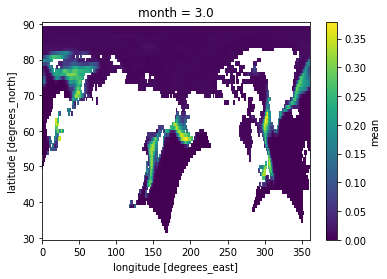

In [32]:
test['mean'].sel(month=3).plot()